# Project Objectives
- Document code, process, findings, and key takeaways.
- Make your process repeateable and your report (notebook) easy to read and follow.
- Ask exploratory questions of your data. Answer questions through charts and statistical tests.
- Construct a model to predict Value ("tax assessment") using classification techniques.
- Refine your work into a Report.
- Be prepared to answer panel questions.

## Business Goals
- Find drivers for tax assessment with zillow data. What are features that can help predict tax assessment?
- Construct a ML classification model that accurately predicts tax assessment.
- Deliver a report that a non-data scientist can read through and understand what steps were taken, why and what was the outcome?

In [1]:
#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats
import sklearn.impute as simpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor



import acquire
import prepare
import explore
import wrangle
import modeling
import env

In [2]:
df0 = acquire.get_zillow_single_fam()

> - ## Acquired the data

In [3]:
df = prepare.prep_zillow(df0)

> - did basic cleaning (removed whitespaces, dropped nulls, renaming columns), 
> - ## Returning a prep file, with some feature engineering

In [4]:
df.head()

,bedrooms,bathrooms,area,tax assessment,year built,taxes yearly,fips
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0
14,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0


In [5]:
##checking the distribution after removing outliers
df.drop(columns=["taxes yearly"],inplace=True)
df,train,validate,test = wrangle.wrangle_zillow_orig(df)



prepared df shape: (1824870, 8)
train shape: (1094922, 8)
validate shape: (364974, 8)
test shape: (364974, 8)


> - dropping yearly taxes due to project requirements (states that it is a result of the target)
> - removed outliers using Tukey (k=1.5)
> - added a binned version of years (decades)
> - created a new column called openness, this will hopefully shine some additional insight into the luxury for the space of a house
> - split data
> - ## Returning a wrangle file with some feature engineering

> - ## do univariate exploration

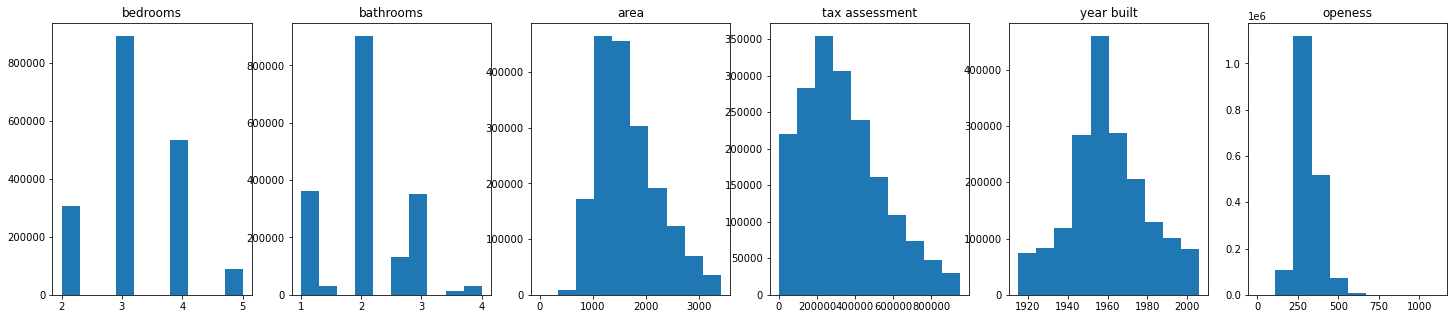

In [6]:
#exploring our basic info
explore.univariate_explore(df[["bedrooms","bathrooms","area","tax assessment", "year built", "openess"]])

# Takeaway
here we see most things are somewhat normally distributed with barthrooms being a bit of an outlier in that remark (looks like due to half baths)

-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-

## This section will be going over exploration

### Bivariate exploration

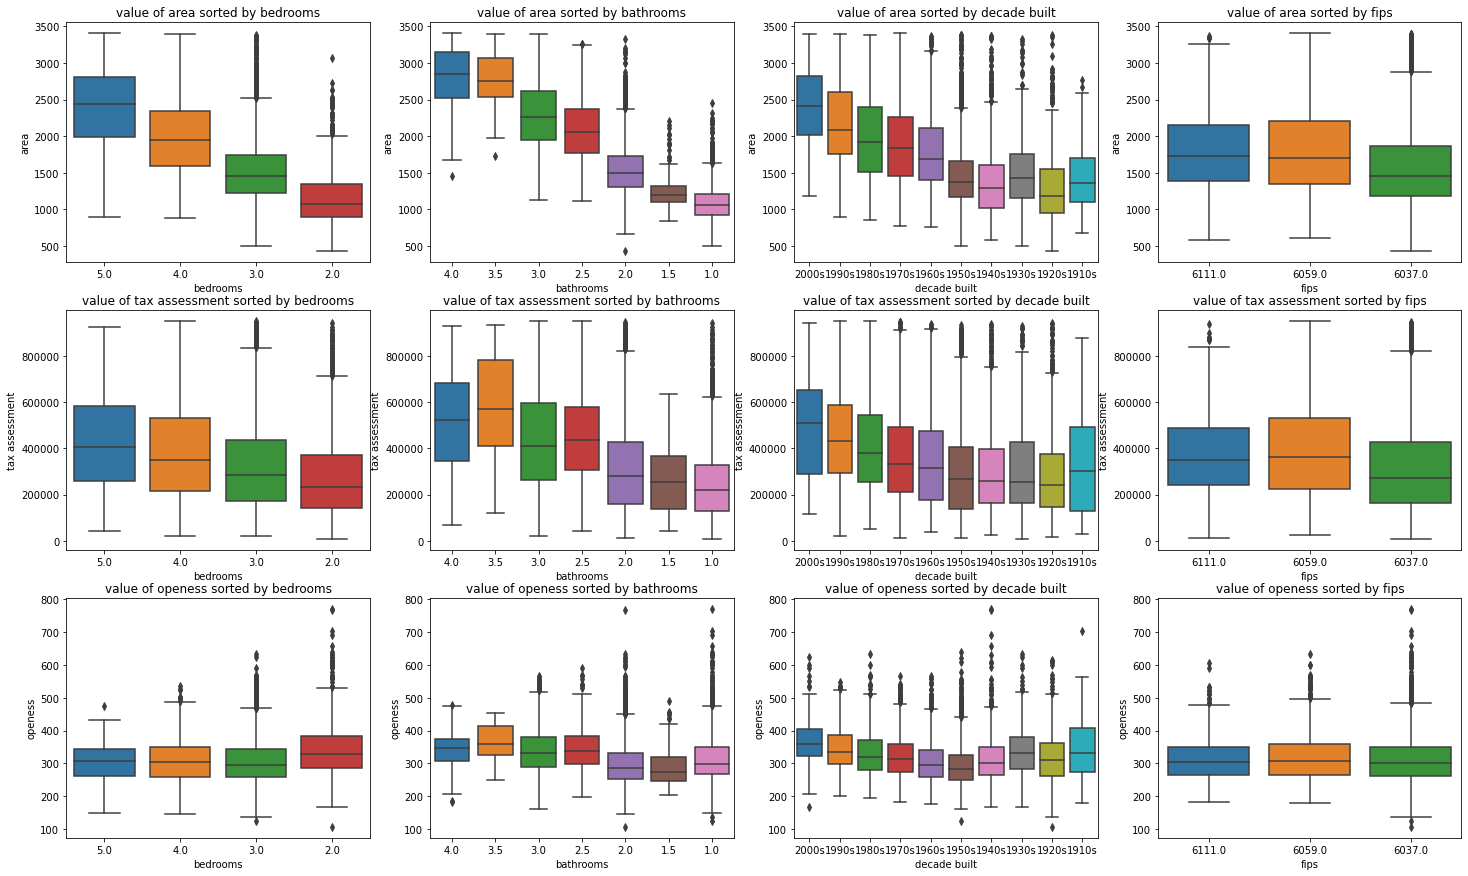

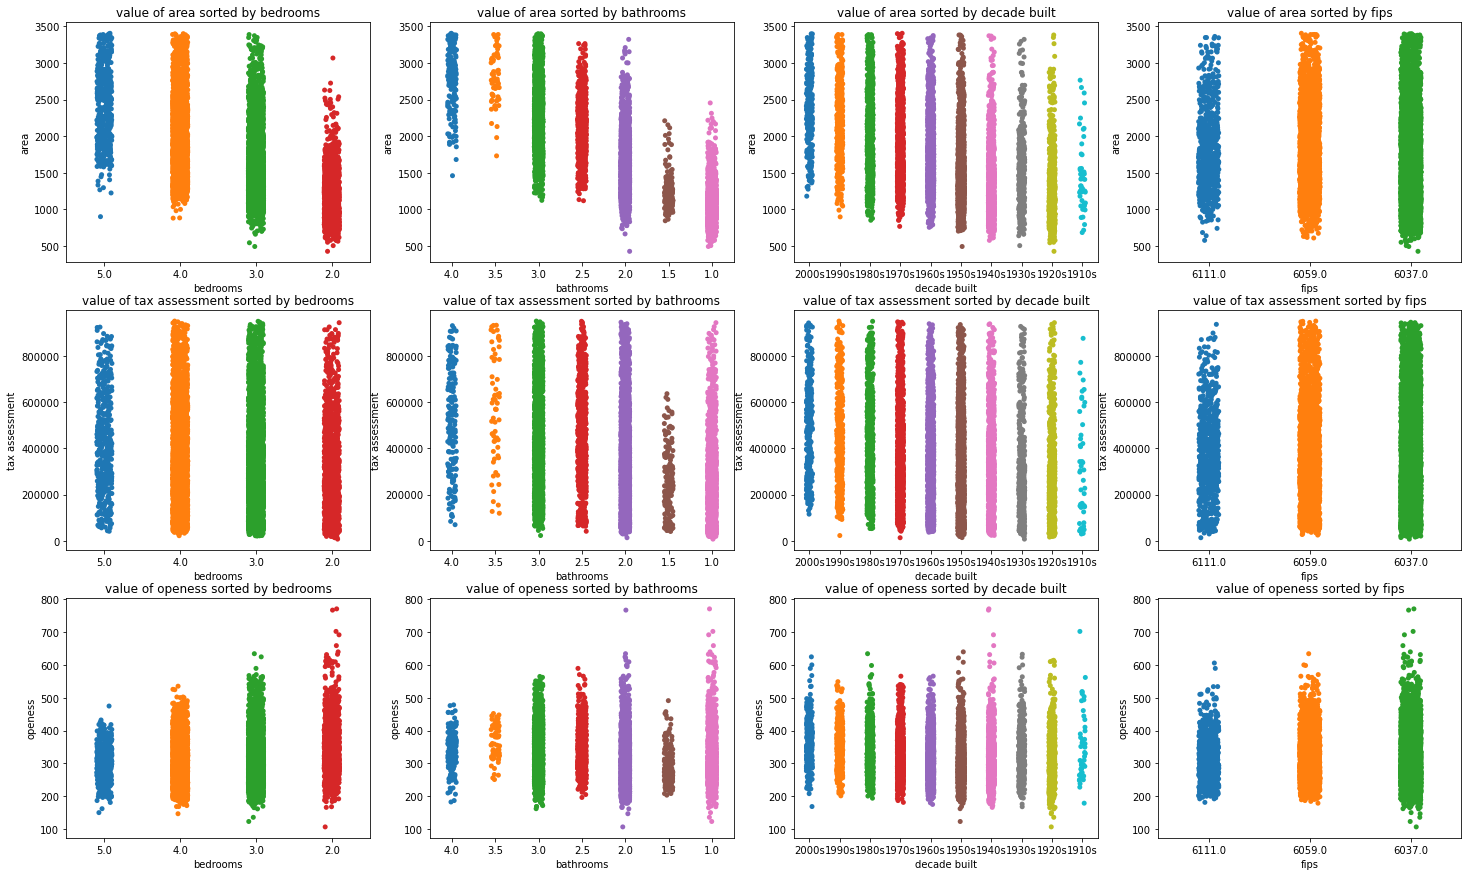

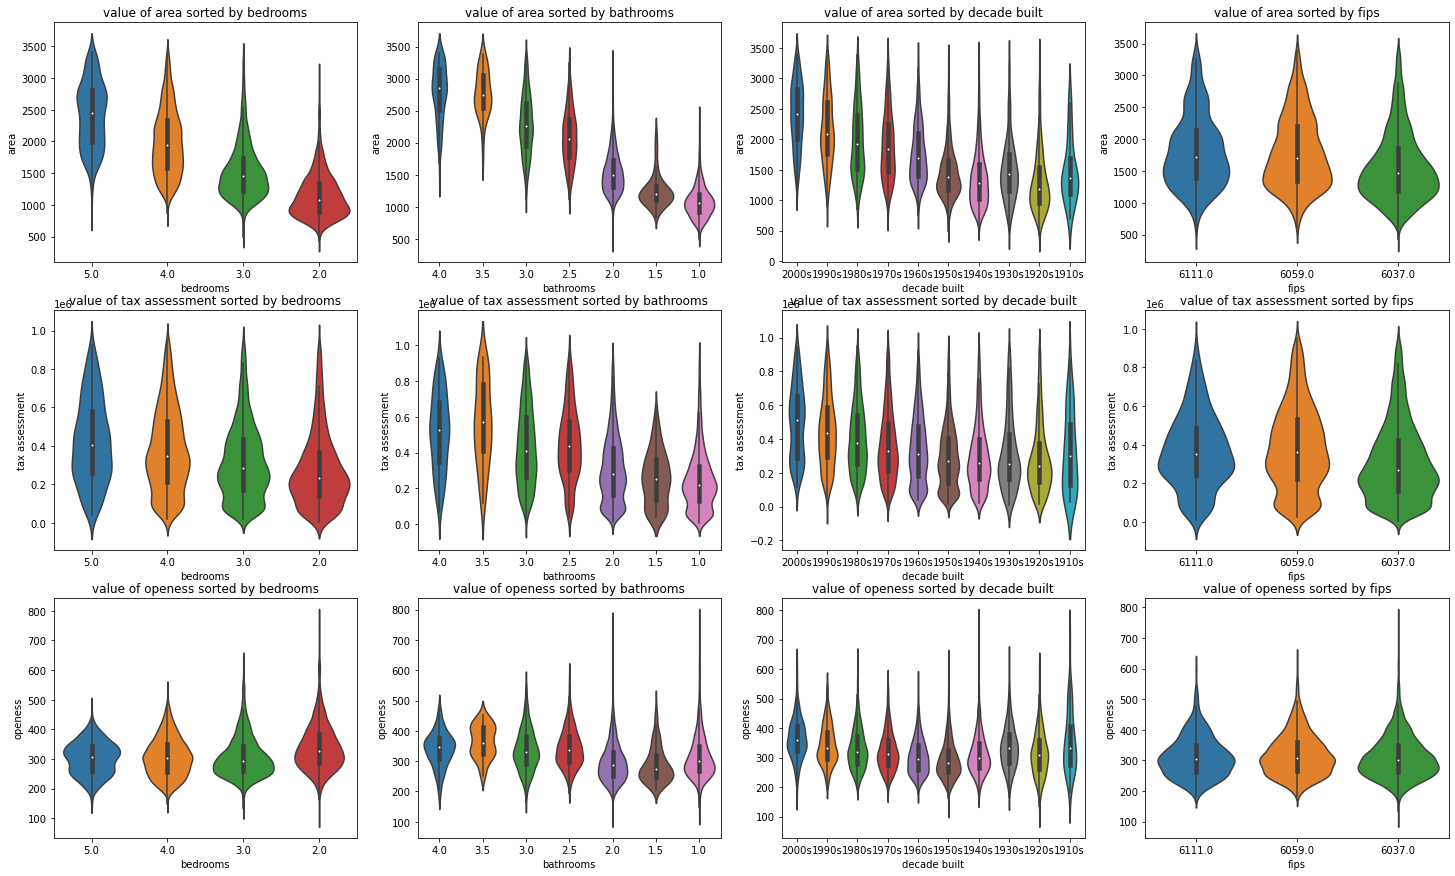

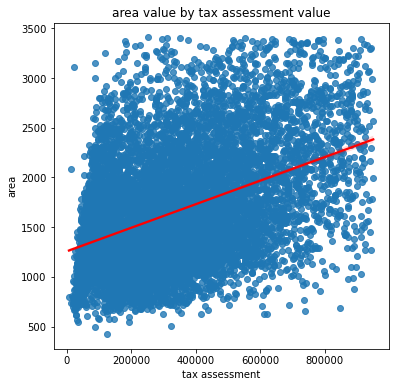

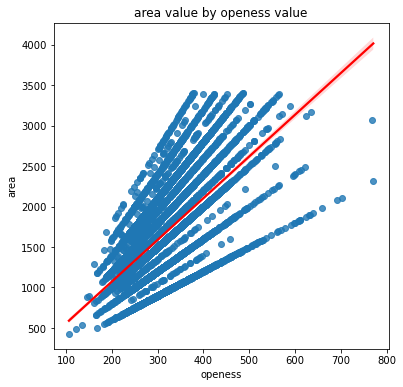

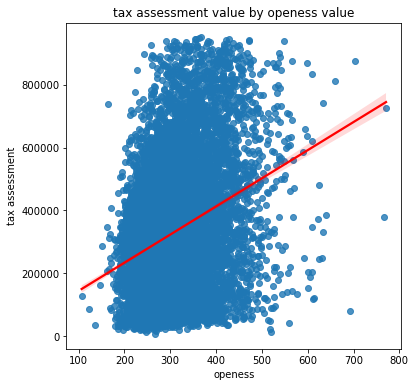

In [7]:
## i break my columns into categorical and numerical variables
cat_vars = ["bedrooms", "bathrooms", "decade built", "fips"] # the categorical variables
num_vars = ["area", "tax assessment", "openess"] # the numerical variables

# i then plot them out using an explore.py created just for this purpose
explore.plot_categorical_and_continuous_vars(train.sample(n=10000, random_state=123),num_vars,cat_vars)
explore.plot_variable_pairs(train.sample(n=10000, random_state=123),num_vars)

# Takeaways
> - more area often has more bathrooms which trends with more bathrooms in turn related with higher tax assessment
> - 3.5 bathrooms is assessmentd highly
> - general trend of area increasing with each decade

# We see certain things have a relation, so let's dive deeper into how they're related with a correlation heat map

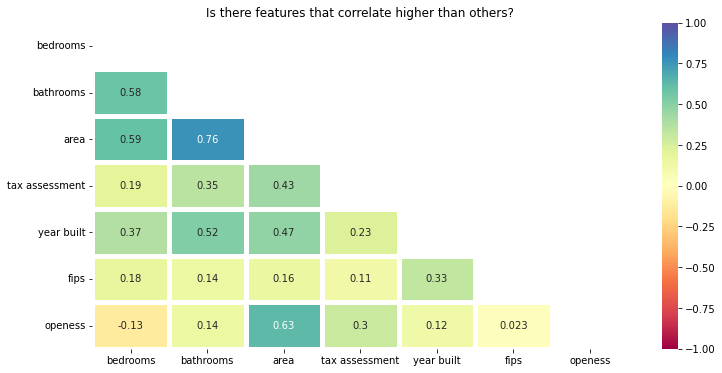

In [8]:
## create a heatmap of relationships between the variables
explore.heatmap_corr(train.sample(n=10000, random_state=123))

# Heatmap takeaways:
strong relationship between tax assessment and  taxes yearly (makes sense since taxes yearly is based off tax assessment)

as well as area and bathrooms (also makes sense, larger house has more room for bathroom)




## Let's start asking our questions

> - **Hypothesis 1 -** 
> - alpha = .05
> - $H_0$ = "The distributions underlying the samples of Tax assessment and Openess are unrelated"
> -
> - $H_a$: "The distributions underlying the samples of Tax assessment and Openess are related"

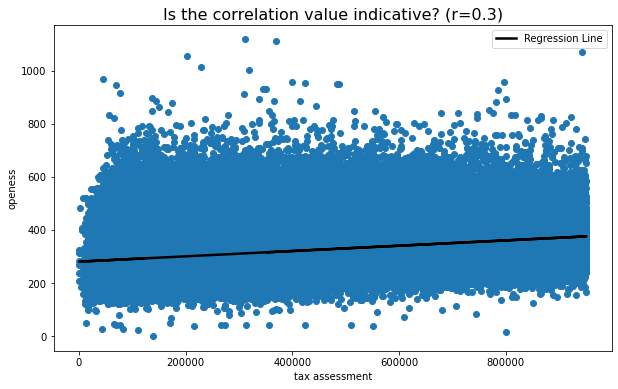

r = 0.2963885284195062

 We reject the null Hypothesis ( T̶h̶a̶t̶ ̶t̶h̶e̶ ̶d̶i̶s̶t̶r̶i̶b̶u̶t̶i̶o̶n̶s̶ ̶u̶n̶d̶e̶r̶l̶y̶i̶n̶g̶ ̶t̶h̶e̶ ̶s̶a̶m̶p̶l̶e̶s̶ ̶o̶f̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶a̶n̶d̶ ̶o̶p̶e̶n̶e̶s̶s̶ ̶a̶r̶e̶ ̶u̶n̶r̶e̶l̶a̶t̶e̶d̶ ) p=0.00000


In [9]:
## data is quantative, mostly normally distributed, and already removed most the outliers
## so will test with pearsonR

explore.pearsonr_corr_explore_plot(train,"tax assessment","openess")

### Correlation/PearsonR takeaway
- here we have a statistical test of PearsonR validating that there is a loose relationship between Tax assessment and Openess with a relationship of .3. this will be useful knowledge in our modelling

-
-
-
-
-

Continuing exploration of the heat map, we will test the Tax assessment mean of each FIPs to see if there is a difference in the means based on location

> - **Hypothesis 2 -** 
> - alpha = .05
> - $H_0$ = "Tax assessment of FIPS has identical average assessments to Tax assessment of other FIPS"
> - $\mu_{Tax assessment (FIPS_{n})} <= \mu_{Tax assessment (FIPS_{n+1})}$.
> -
> - $H_a$: "Tax assessment of FIPS is not equal to Tax assessment of other FIPS"
> - $\mu_{Tax assessment (FIPS_{n})} > \mu_{Tax assessment (FIPS_{n+1})}$. 

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=43.64873, p=0.00000

 We reject the null Hypothesis ( t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶f̶i̶p̶s̶6̶0̶5̶9̶.̶0̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶f̶i̶p̶s̶6̶0̶3̶7̶.̶0̶ ) t=14.67061, p=0.00000
-----------------------------
we can accept that there are equal variance in these two groups with 0.49 certainty Flag=T stat=0.47269, p=0.49177

 We reject the null Hypothesis ( t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶f̶i̶p̶s̶6̶1̶1̶1̶.̶0̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶f̶i̶p̶s̶6̶0̶3̶7̶.̶0̶ ) t=7.69123, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=20.93031, p=0.00000

 We fail to reject the null hypothesis ( tax assessment of fips6111

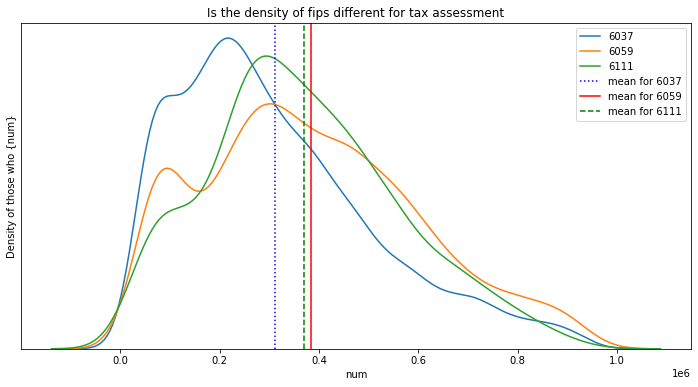

In [10]:
## will do test for homogeneity of variance and pass as flag to TTest using levene test
## samples are sufficent size, and mostly normally distributed


explore.cat_and_num_explore_plot(train.sample(n=10000, random_state=123),"fips","tax assessment")

> - ## Takeaway on TTest for FIPS and Tax assessment
> - the 2 sided TTest yielded interesting results in that the the samples of FIPS did varied enough to pass our measure of statistical significance (alpha = .05); rejecting our null hypothesis. This would indicate that seperating the data by FIPS will result in a significant difference. This will be important for our modeling

-
-
-
-
-

> - **Hypothesis 3 -** 
> - alpha = .05
> - $H_0$ = "Amount of bedrooms is independant of the amount bathrooms"
> - $H_a$:  "Amount of bedrooms is not independant of the amount bathrooms"

In [11]:
df1 = pd.crosstab(train.bedrooms,train.bathrooms)

alpha = .05

chi2, p, degf, expected = stats.chi2_contingency(df1)

H0 = (f"{df1.index.name} is independant of {df1.columns.name}")
H1 = (f"{df1.index.name} is not independant of being {df1.columns.name}")

#print('Observed')
#print(df1.values)
#print('---\nExpected')
#print(expected)
print(f'---\nchi^2 = {chi2:.4f}, p = {p:.5f}, degf = {degf}')
if p>alpha:
    print(f"due to p={p:.5f} > α={alpha} we fail to reject our null hypothesis\n({H0})")
else:
    print(f"due to p = {p:.5f} < α = {alpha} we reject our null hypothesis\n(", '\u0336'.join(H0) + '\u0336' ,")")

---
chi^2 = 510875.3674, p = 0.00000, degf = 18
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
( b̶e̶d̶r̶o̶o̶m̶s̶ ̶i̶s̶ ̶i̶n̶d̶e̶p̶e̶n̶d̶a̶n̶t̶ ̶o̶f̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶s̶ )


> - ## Takeaway on CHI2 for Bedrooms and Bathroom
> - The CHI^2 test provided a statistically significant result that allows us to reject our null hypothesis that bedrooms is independant of bathrooms, signifiying that there is a relationship that we can utilize in our modeling

-
-
-
-
-

# Verify feature selection going into modeling
we see above that most of our features have bearing on assessment, we will drop decade built since it is more explicitly shown in year built.

we will also run SelectKbest and Recursive Feature Elimination as a sanity check

In [12]:
df.drop(columns="decade built",inplace=True)
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = wrangle.split_tvt_continuous(df,"tax assessment")

train -> (1094922, 7)
validate -> (364974, 7)
test -> (364974, 7)


In [13]:
print("-----------------------------\n")
wrangle.select_kbest(X_train,y_train,3)
print("^^^^^^^^^^^^KBest^^^^^^^^^^\n")
print("-----------------------------\n")
print("vvvvvvvvvvvvvRFEvvvvvvvvvvvvv")
wrangle.rfe(X_train,y_train,3)

-----------------------------

['bathrooms', 'area', 'openess']
^^^^^^^^^^^^KBest^^^^^^^^^^

-----------------------------

vvvvvvvvvvvvvRFEvvvvvvvvvvvvv
           rfe_ranking
bedrooms             1
bathrooms            1
openess              1


,Var,Rank
0,bedrooms,1
1,bathrooms,1
5,openess,1
4,fips,2
3,year built,3
2,area,4


# Takeaways
all of our remaining features have a good correlation or weight in deciding Tax Assessment and we will keep them for modeling

-
-
-
-
-
-
-
-
-
-

# Modeling

In [14]:
columns_to_scale = train.drop(columns="tax assessment").columns.tolist()

X_train, X_validate, X_test = train[columns_to_scale], validate[columns_to_scale], test[columns_to_scale]
y_train, y_validate, y_test = train["tax assessment"], validate["tax assessment"], test["tax assessment"]

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train) ##only use fit_transform for training, after that use transform (equations are created)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [15]:
y_train,y_validate,metric_df = modeling.model_baseline(y_train,y_validate,"tax assessment")

RMSE using Mean
Train/In-Sample:  206182.93 
Validate/Out-of-Sample:  206167.19
RMSE using Median
Train/In-Sample:  208967.39 
Validate/Out-of-Sample:  208901.33


NameError: name 'n' is not defined

# Baseline modeling takeaways
we ran two basic models using the mean and the median, and utilized the Root Mean Squared Error as the determinate for which to keep moving forward (lowest value). This time it was Mean, with a RMSE of apporx 206k

In [ ]:
y_train,y_validate,temp = \
        modeling.model_polynomial(X_train_scaled,X_validate_scaled,y_train,y_validate,"tax assessment",6)

metric_df = pd.concat([metric_df,temp],axis=0).reset_index(drop=True)
   
metric_df

NameError: name 'modeling' is not defined

In [ ]:
metric_df.loc[0]

,model,rmse_train,rmse_validate,r^2_validate
0,baseline_mean,206182.928531,206167.189802,0.000000
0,Polynomial - degree 6,180418.257897,180390.639069,0.234422


Text(0.5, 1.0, 'Scaled')

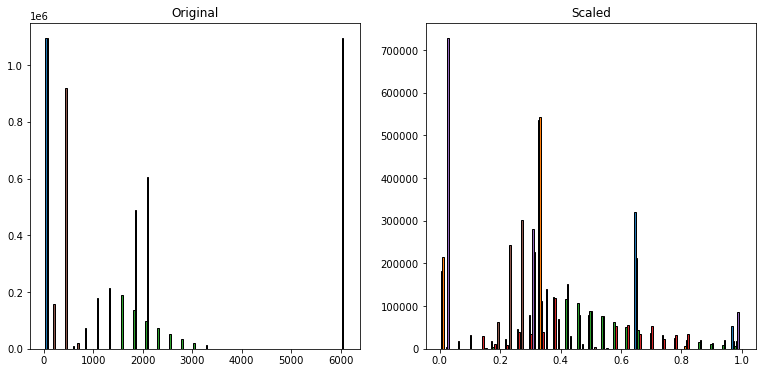

In [ ]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

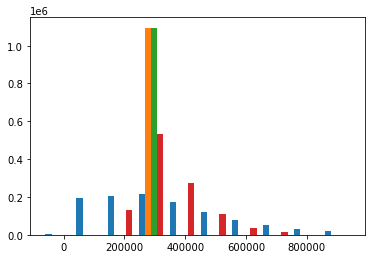

In [ ]:
baseline_mean = y_train.mean()
baseline_median = y_train.median()

plt.hist(y_train)
plt.axvline(x=baseline_median,color="black",label="median")
plt.axvline(x=baseline_mean,color="red",label="mean")
plt.xlabel("Tax Assement")
plt.ylabel("COUNT")
plt.legend()
plt.title("histogram of Tax assessment with baselines")
plt.show()

In [ ]:
##want smallest error

rmse_mean_train = mean_squared_error(y_train["tax assessment"], y_train["mean"])**(1/2)
rmse_mean_validate = mean_squared_error(y_validate["tax assessment"], y_validate["mean"])**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_mean_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_mean_validate, 2))


rmse_median_train = mean_squared_error(y_train["tax assessment"], y_train["median"])**(1/2)
rmse_median_validate = mean_squared_error(y_validate["tax assessment"], y_validate["median"])**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_median_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_median_validate, 2))

RMSE using Mean
Train/In-Sample:  206182.93 
Validate/Out-of-Sample:  206167.19
RMSE using Median
Train/In-Sample:  208967.39 
Validate/Out-of-Sample:  208901.33


In [ ]:
metric_df = pd.DataFrame(
    data=[{
        "model":"mean_baseline",
        "rmse_validate":rmse_mean_validate,
        "r^2_validate":explained_variance_score(y_validate["tax assessment"],y_validate["mean"])
    }]
)

In [ ]:
# create the model object
linreg = LinearRegression()

# fit the model to our training data. 
linreg.fit(X_train_scaled, y_train["tax assessment"])

# predict train
y_train['tip_pred_linreg'] = linreg.predict(X_train_scaled)

# evaluate: rmse
rmse_linreg_train = mean_squared_error(y_train["tax assessment"], y_train.tip_pred_linreg)**(1/2)

# predict validate
y_validate['tip_pred_linreg'] = linreg.predict(X_validate_scaled)

# evaluate: rmse
rmse_linreg_validate = mean_squared_error(y_validate["tax assessment"], y_validate.tip_pred_linreg)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_linreg_train, 
      "\nValidation/Out-of-Sample: ", rmse_linreg_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  184579.22543636925 
Validation/Out-of-Sample:  184352.64047636616


In [ ]:
metric_df.loc[len(metric_df.index)] = ["OLS lm 1",
                                        rmse_linreg_train,
                                        explained_variance_score(y_validate["tax assessment"],y_validate["tip_pred_linreg"])
                                    ]

In [ ]:
# create the model object
l_lars = LassoLars(alpha=1)

# fit the model to our training data. 
l_lars.fit(X_train_scaled, y_train["tax assessment"])

# predict train
y_train['tip_pred_l_lars'] = l_lars.predict(X_train_scaled)

# evaluate: rmse
rmse_l_lars_train = mean_squared_error(y_train["tax assessment"], y_train.tip_pred_l_lars)**(1/2)

# predict validate
y_validate['tip_pred_l_lars'] = l_lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_l_lars_validate = mean_squared_error(y_validate["tax assessment"], y_validate.tip_pred_l_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_l_lars_train, 
      "\nValidation/Out-of-Sample: ", rmse_l_lars_validate)

metric_df.loc[len(metric_df.index)] = ["Lasso lars 1",
                                        rmse_l_lars_train,
                                        explained_variance_score(y_validate["tax assessment"],y_validate["tip_pred_l_lars"])
                                    ]

RMSE for Lasso + Lars
Training/In-Sample:  184634.85917005225 
Validation/Out-of-Sample:  184408.9641174384


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [ ]:
# create the model object
glm = TweedieRegressor(power=1,alpha=0)

# fit the model to our training data. 
glm.fit(X_train_scaled, y_train["tax assessment"])

# predict train
y_train['tip_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_glm_train = mean_squared_error(y_train["tax assessment"], y_train.tip_pred_glm)**(1/2)

# predict validate
y_validate['tip_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_glm_validate = mean_squared_error(y_validate["tax assessment"], y_validate.tip_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_glm_train, 
      "\nValidation/Out-of-Sample: ", rmse_glm_validate)
    
metric_df.loc[len(metric_df.index)] = ["Tweedie 1",
                                        rmse_glm_train,
                                        explained_variance_score(y_validate["tax assessment"],y_validate["tip_pred_glm"])
                                    ]

metric_df

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  184687.39674505775 
Validation/Out-of-Sample:  184457.39753317708


,model,rmse_validate,r^2_validate
0,mean_baseline,206167.189802,0.000000
1,OLS lm 1,184579.225436,0.200424
2,Lasso lars 1,184634.859170,0.199936
3,Tweedie 1,184687.396745,0.199516


In [ ]:

pf = PolynomialFeatures(degree=2)

X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)


# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train["tax assessment"])

# predict train
y_train['tip_pred_lm2'] = lm2.predict(X_train_degree2)

y_train

# evaluate: rmse
rmse_pf_train = mean_squared_error(y_train["tax assessment"], y_train.tip_pred_lm2)**(1/2)

# predict validate
y_validate['tip_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_pf_validate = mean_squared_error(y_validate["tax assessment"], y_validate.tip_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_pf_train, 
      "\nValidation/Out-of-Sample: ", rmse_pf_validate)

metric_df.loc[len(metric_df.index)] = ["Polynomial Fit 1",
                                        rmse_pf_train,
                                        explained_variance_score(y_validate["tax assessment"],y_validate["tip_pred_lm2"])
                                    ]

metric_df

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  182573.80237040247 
Validation/Out-of-Sample:  182357.39512952784


,model,rmse_validate,r^2_validate
0,mean_baseline,206167.189802,0.000000
1,OLS lm 1,184579.225436,0.200424
2,Lasso lars 1,184634.859170,0.199936
3,Tweedie 1,184687.396745,0.199516
4,Polynomial Fit 1,182573.802370,0.217638


In [ ]:
y_train

,tax assessment,mean,median,tip_pred_linreg,tip_pred_l_lars,tip_pred_glm,tip_pred_lm2
694227,122775.0,335197.564293,301198.0,357082.066211,356286.661673,354104.256124,323980.625816
2028661,50070.0,335197.564293,301198.0,220761.538852,220989.124877,229519.949176,225729.616051
1927794,62911.0,335197.564293,301198.0,272909.234436,272620.034972,272647.300005,257045.557457
1373870,240080.0,335197.564293,301198.0,328450.880935,332459.970619,321822.242209,298177.725426
1352870,186514.0,335197.564293,301198.0,275381.794519,281244.566303,279916.399108,264981.374840
...,...,...,...,...,...,...,...
535094,461000.0,335197.564293,301198.0,262766.508730,262384.629538,266167.768531,221697.196617
1009979,596680.0,335197.564293,301198.0,513237.574654,509766.373084,515516.589649,532749.091637
129601,555287.0,335197.564293,301198.0,658892.887724,640608.913788,748445.187340,513663.505699
524621,762194.0,335197.564293,301198.0,547035.835478,538973.811966,548748.038823,516584.152184


In [ ]:
X_train_scaled

array([[0.33333333, 0.66666667, 0.47723935, 0.76923077, 0.        ,
        0.24254956],
       [0.33333333, 0.        , 0.31306902, 0.35164835, 0.        ,
        0.23889363],
       [0.33333333, 0.33333333, 0.36622614, 0.49450549, 0.        ,
        0.22344916],
       ...,
       [0.33333333, 0.83333333, 0.95917768, 0.49450549, 1.        ,
        0.44989915],
       [0.66666667, 0.5       , 0.89779736, 0.51648352, 0.2972973 ,
        0.4211108 ],
       [0.33333333, 0.33333333, 0.34038179, 0.62637363, 0.2972973 ,
        0.20769132]])